<h1>Считывание данных</h1>

In [54]:
from time import time
from IPython import get_ipython
from IPython.display import Audio, display


class Beeper:

    def __init__(self, threshold, **audio_kwargs):
        self.threshold = threshold
        self.start_time = None    # time in sec, or None
        self.audio = audio_kwargs

    def pre_execute(self):
        if not self.start_time:
            self.start_time = time()

    def post_execute(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            audio = Audio(**self.audio, autoplay=True)
            display(audio)
        self.start_time = None
    
    
    def exception(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            audio = Audio(**self.audio, autoplay=True)
            display(audio)
        self.start_time = None


beeper = Beeper(5, url='./alert.wav')

ipython = get_ipython()
ipython.events.register('pre_execute', beeper.pre_execute)
ipython.events.register('post_execute', beeper.post_execute)

def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url='./horn.wav', autoplay=True))
    
get_ipython().set_custom_exc((Exception,), play_sound)

In [55]:
# %matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file = "aes_data.xlsx"

data = pd.read_excel(file)

df = data.drop([0,1,2], axis=0)
cols_fillna = df.columns.values
for col in cols_fillna[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    
pump_in_cols = df.columns.values[1:6]
pump_out_cols = df.columns.values[6:11]
pump_mass_cols = df.columns.values[11:16]
pump_temp_col = df.columns.values[16]
pump_amper_cols = df.columns.values[17:22]
pump_revs_cols = df.columns.values[22:27]
pump_volt_cols = df.columns.values[27:31]
pump_turbine_col = df.columns.values[31]
pump_reactor_col = df.columns.values[32]


# df[cols_fillna[-1]][df[cols_fillna[-1]].isnull()]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.head()


,Время,10LAB11CP002_XQ01,10LAB12CP002_XQ01,10LAB13CP002_XQ01,10LAB14CP002_XQ01,10LAB15CP002_XQ01,10LAB11CP003_XQ01,10LAB12CP003_XQ01,10LAB13CP003_XQ01,10LAB14CP003_XQ01,10LAB15CP003_XQ01,10LAB11CF001_XQ01,10LAB12CF001_XQ01,10LAB13CF001_XQ01,10LAB14CF001_XQ01,10LAB15CF001_XQ01,10LAB00FT902_XQ01,10LAC11CE021_XQ01,10LAC12CE021_XQ01,10LAC13CE021_XQ01,10LAC14CE021_XQ01,10LAC15CE021_XQ01,10LAC11CS001A_XQ01,10LAC12CS001A_XQ01,10LAC13CS001A_XQ01,10LAC14CS001A_XQ01,10LAC15CS001A_XQ01,10BBA00CE010_XQ01,10BBB00CE010_XQ01,10BBC00CE010_XQ01,10BBD00CE010_XQ01,10MKA10CE912_XQ01,10JKS00FU901_XQ01
0,NaN,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание,Дост--Описание
1,NaN,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ ВСАС ПИТ НАС 0-1.6 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост Р ПИТВ НАП ПИТ НАС 0-16 МПА,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост F ПИТ В НАП ПИТ НАС 0-500 КГ/С,дост ВЧСЛ СИГН Т ПИТВ Д 0-200 ГРАД,дост ТОК 10LAC11AP001 0-600 А,дост ТОК 10LAC12AP001 0-600 А,дост ТОК 10LAC13AP001 0-600 А,дост ТОК 10LAC14AP001 0-600 А,дост ТОК 10LAC15AP001 0-600 А,дост Частота вращения ротора электродвигателя,дост Частота вращения ротора электродвигателя,дост Частота вращения ротора электродвигателя,дост Частота вращения ротора электродвигателя,дост Частота вращения ротора электродвигателя,дост U НА СЕКЦ BBA 0-13 КВ,дост U НА СЕКЦ BBB 0-13 КВ,дост U НА СЕКЦ BBC 0-13 КВ,дост U НА СЕКЦ BBD 0-13 КВ,дост -100-1500 MBT,дост Среднее значение мощности реактора
2,NaN,МПа,МПа,МПа,МПа,МПа,МПа,МПа,МПа,МПа,МПа,кг/с,кг/с,кг/с,кг/с,кг/с,°C,A,A,A,A,A,об/мин,об/мин,об/мин,об/мин,об/мин,кВ,кВ,кВ,кВ,МВт,МВт
3,01.01.19 00:00:00,0.80,0.76,0.75,0.80,0.77,0.7,9.4,9.5,0.8,9.5,-1,293,383,1,343,167,0,282,290,1,280,0,2995,2994,0,2995,10.5,10.2,10.5,10.4,576,1803
4,01.01.19 01:00:00,0.80,0.76,0.75,0.80,0.77,0.7,9.4,9.5,0.8,9.5,-1,294,383,1,342,167,0,278,290,1,277,0,2995,2996,0,2995,10.5,10.2,10.5,10.4,575,1795


<h1>Первичная фильтрация данных</h1>
<p>убираем отрицательные или слишком большие значения</p>
<p>+ графики массовой подачи для всех насосов</p>


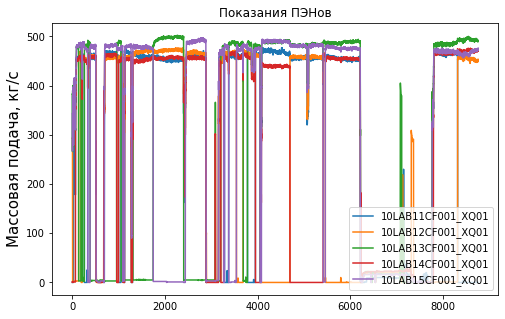

In [56]:
df[pump_in_cols[2]] = df[pump_in_cols[2]].apply(lambda x: x if x<=8 else x-x//1)   


for col in df.columns.values[1:]:
    df[col] = df[col].apply(lambda x: 0 if x<0 else x)

for col in pump_mass_cols:
    df[col] = df[col].apply(lambda x: x if x<510 else 0)    
    
plt.rcParams["figure.figsize"] = (8,5)

df.plot(use_index=True, y=pump_mass_cols, title='Показания ПЭНов')
plt.title('Показания ПЭНов')
plt.ylabel('Массовая подача, кг/с', fontsize=15)
plt.legend(loc='lower right')
plt.show()
# ax.show()


<h1>Расчеты КПД</h1>

In [60]:
from iapws import IAPWS97, IAPWS95

def eff_func(row, pump_num):
    p1 = df[f'10LAB{pump_num}CP002_XQ01'][row]
    p2 = df[f'10LAB{pump_num}CP003_XQ01'][row]
    G = df[f'10LAB{pump_num}CF001_XQ01'][row]
    t = df["10LAB00FT902_XQ01"][row]
    I = df[f"10LAC{pump_num}CE021_XQ01"][row]
    U = df["10BBA00CE010_XQ01"][row]
    
    if all([(p2-p1)*G,U*I, t, p2, p1]):
        try:
            rho = IAPWS97(P=(p1+p2)/2, T=t+273).rho
        except:
            print(p1,p2,G,t, pump_num)
            raise Exception('here')
        ef = (p2-p1)*1000*G/(U*I*rho)/np.sqrt(3)
        ef = 0 if ef < 0 or ef >= 1 else ef
        
        return ef / np.sqrt(3)
        
    else:
        return 0


pump_1_eff = df.apply(lambda x: eff_func(x.name, 11), axis=1)
pump_2_eff = df.apply(lambda x: eff_func(x.name, 12), axis=1)
pump_3_eff = df.apply(lambda x: eff_func(x.name, 13), axis=1)
pump_4_eff = df.apply(lambda x: eff_func(x.name, 14), axis=1)
pump_5_eff = df.apply(lambda x: eff_func(x.name, 15), axis=1)

pump_eff_data = {
    'pump_1_eff':pump_1_eff,
    'pump_2_eff':pump_2_eff,
    'pump_3_eff':pump_3_eff,
    'pump_4_eff':pump_4_eff,
    'pump_5_eff':pump_5_eff,
}



Text(0, 0.5, 'КПД насоса')

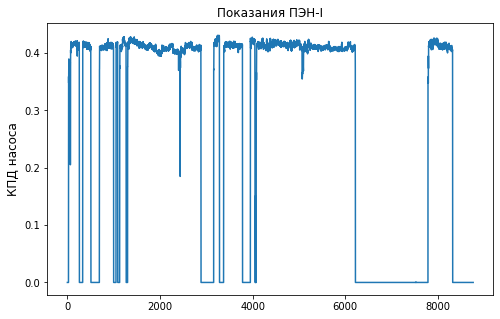

In [61]:
fig1 = plt.figure(figsize=(8, 5))
ax1 = fig1.add_subplot(111)

plot = pump_eff_data['pump_1_eff'].plot(title="Показания ПЭН-I", axes=ax1)
plt.ylabel("КПД насоса", fontsize=12)

<h1>Разделение на сегменты</h1>

In [62]:
def divide_to_segments_by_eff(column, limiter):
    segm_start = None
    segm_end = None

    segments = []

    for ind,item in pump_eff_data[column].iteritems():
        if item>limiter:
            if segm_start is None:
                segm_start = ind
        else:
            if segm_start is not None and ind != segm_start:
                segm_end = ind

        if segm_start is not None and segm_end is not None:
            segments.append((segm_start-2,segm_end-3))
            segm_start, segm_end = None, None
    
    return segments

def divide_to_segments(column, limiter):
    segm_start = None
    segm_end = None

    segments = []

    for ind,item in df[column].iteritems():
        if item>limiter:
            if segm_start is None:
                segm_start = ind
        else:
            if segm_start is not None and ind != segm_start:
                segm_end = ind

        if segm_start is not None and segm_end is not None:
            segments.append((segm_start-2,segm_end-3))
            segm_start, segm_end = None, None
    
    return segments
        
# segments1 = divide_to_segments(pump_mass_cols[0], 350)
# segments2 = divide_to_segments(pump_mass_cols[1], 350)
# segments3 = divide_to_segments(pump_mass_cols[2], 350)
# segments4 = divide_to_segments(pump_mass_cols[3], 350)
# segments5 = divide_to_segments(pump_mass_cols[4], 350)

segments1 = divide_to_segments_by_eff('pump_1_eff', 0.1)
segments2 = divide_to_segments_by_eff('pump_2_eff', 0.1)
segments3 = divide_to_segments_by_eff('pump_3_eff', 0.1)
segments4 = divide_to_segments_by_eff('pump_4_eff', 0.1)
segments5 = divide_to_segments_by_eff('pump_5_eff', 0.1)


pump_mass_1_filtred = pd.concat([df[pump_mass_cols[0]][i[0]-2:i[1]-3] for i in segments1],  ignore_index=True)

filtred_data = {
    'pump_1_in': pd.concat([df[pump_in_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_in': pd.concat([df[pump_in_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_in': pd.concat([df[pump_in_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_in': pd.concat([df[pump_in_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_in': pd.concat([df[pump_in_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
    
    'pump_1_out': pd.concat([df[pump_out_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_out': pd.concat([df[pump_out_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_out': pd.concat([df[pump_out_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_out': pd.concat([df[pump_out_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_out': pd.concat([df[pump_out_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
    
    
    'pump_1_mass': pd.concat([df[pump_mass_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_mass': pd.concat([df[pump_mass_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_mass': pd.concat([df[pump_mass_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_mass': pd.concat([df[pump_mass_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_mass': pd.concat([df[pump_mass_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
 
    'pump_1_eff': pd.concat([pump_1_eff[i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_eff': pd.concat([pump_2_eff[i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_eff': pd.concat([pump_3_eff[i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_eff': pd.concat([pump_4_eff[i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_eff': pd.concat([pump_5_eff[i[0]:i[1]] for i in segments5],  ignore_index=True),
    
    'pump_1_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_temp': pd.concat([df[pump_temp_col][i[0]:i[1]] for i in segments5],  ignore_index=True),
    
    
    'pump_1_amper': pd.concat([df[pump_amper_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_amper': pd.concat([df[pump_amper_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_amper': pd.concat([df[pump_amper_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_amper': pd.concat([df[pump_amper_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_amper': pd.concat([df[pump_amper_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),

    'pump_1_revs': pd.concat([df[pump_revs_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
    'pump_2_revs': pd.concat([df[pump_revs_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
    'pump_3_revs': pd.concat([df[pump_revs_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
    'pump_4_revs': pd.concat([df[pump_revs_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
    'pump_5_revs': pd.concat([df[pump_revs_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
    
#     'pump_1_volt': pd.concat([df[pump_volt_cols[0]][i[0]:i[1]] for i in segments1],  ignore_index=True),
#     'pump_2_volt': pd.concat([df[pump_volt_cols[1]][i[0]:i[1]] for i in segments2],  ignore_index=True),
#     'pump_3_volt': pd.concat([df[pump_volt_cols[2]][i[0]:i[1]] for i in segments3],  ignore_index=True),
#     'pump_4_volt': pd.concat([df[pump_volt_cols[3]][i[0]:i[1]] for i in segments4],  ignore_index=True),
#     'pump_5_volt': pd.concat([df[pump_volt_cols[4]][i[0]:i[1]] for i in segments5],  ignore_index=True),
}
    
    
filtred_df = pd.DataFrame(filtred_data)

# for i in segments1:
#     print('--',pump1_eff[i[0]], pump1_eff[i[1]])
#     pump1_eff[i[0]:i[1]].plot()



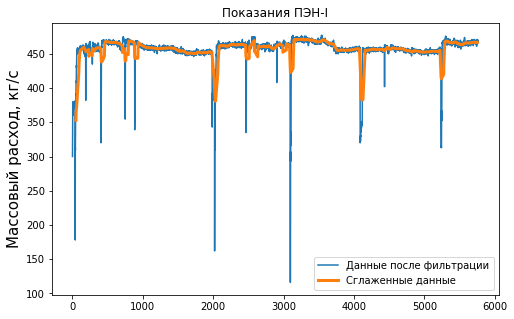

In [63]:
fig2 = plt.figure(figsize=(8, 5))
ax2 = fig2.add_subplot(111)

filtred_data['pump_1_mass'].plot(title="Показания ПЭН-I", axes=ax2, label='Данные после фильтрации')

plt.ylabel("Массовый расход, кг/c", fontsize=15)

rolled = pump_mass_1_filtred.rolling(50).mean()
rolled.plot(linewidth=3, axes=ax2, label='Сглаженные данные')

ax2.legend(loc='lower right')


<h1>Сглаживание</h1>

In [64]:
def smooth(data, rolling=10, min_periods=1):
    f_max = data.max()
    f_norm = data/f_max
    return f_norm.rolling(rolling, min_periods).mean()

smoothed_data = {
    'pump_1_in':smooth(filtred_data['pump_1_in']),
    'pump_2_in':smooth(filtred_data['pump_2_in']),
    'pump_3_in':smooth(filtred_data['pump_3_in']),
    'pump_4_in':smooth(filtred_data['pump_4_in']),
    'pump_5_in':smooth(filtred_data['pump_5_in']),
    
    
    'pump_1_out':smooth(filtred_data['pump_1_out']),
    'pump_2_out':smooth(filtred_data['pump_2_out']),
    'pump_3_out':smooth(filtred_data['pump_3_out']),
    'pump_4_out':smooth(filtred_data['pump_4_out']),
    'pump_5_out':smooth(filtred_data['pump_5_out']),
    
    
    'pump_1_mass':smooth(filtred_data['pump_1_mass']),
    'pump_2_mass':smooth(filtred_data['pump_2_mass']),
    'pump_3_mass':smooth(filtred_data['pump_3_mass']),
    'pump_4_mass':smooth(filtred_data['pump_4_mass']),
    'pump_5_mass':smooth(filtred_data['pump_5_mass']),
    
    'pump_1_eff':smooth(filtred_data['pump_1_eff']),
    'pump_2_eff':smooth(filtred_data['pump_2_eff']),
    'pump_3_eff':smooth(filtred_data['pump_3_eff']),
    'pump_4_eff':smooth(filtred_data['pump_4_eff']),
    'pump_5_eff':smooth(filtred_data['pump_5_eff']),
    
    'pump_1_temp':smooth(filtred_data['pump_1_temp'], rolling=10),
    'pump_2_temp':smooth(filtred_data['pump_2_temp'], rolling=10),
    'pump_3_temp':smooth(filtred_data['pump_3_temp'], rolling=10),
    'pump_4_temp':smooth(filtred_data['pump_4_temp'], rolling=10),
    'pump_5_temp':smooth(filtred_data['pump_5_temp'], rolling=10),
    
    'pump_1_revs':smooth(filtred_data['pump_1_revs']),
    'pump_2_revs':smooth(filtred_data['pump_2_revs']),
    'pump_3_revs':smooth(filtred_data['pump_3_revs']),
    'pump_4_revs':smooth(filtred_data['pump_4_revs']),
    'pump_5_revs':smooth(filtred_data['pump_5_revs']),
    
    'pump_1_amper':smooth(filtred_data['pump_1_amper']),
    'pump_2_amper':smooth(filtred_data['pump_2_amper']),
    'pump_3_amper':smooth(filtred_data['pump_3_amper']),
    'pump_4_amper':smooth(filtred_data['pump_4_amper']),
    'pump_5_amper':smooth(filtred_data['pump_5_amper']),
}



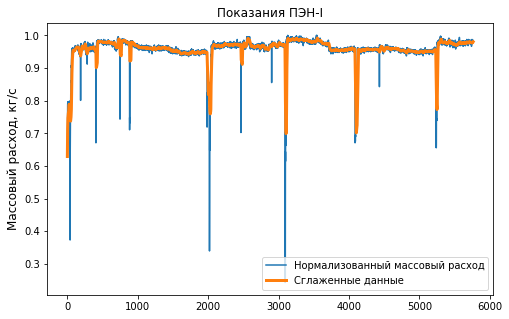

In [65]:

fig3 = plt.figure(figsize=(8, 5))
ax3 = fig3.add_subplot(111)


pump_mass_1_filtred
pump_mass_1_max = filtred_data['pump_1_mass'].max()

pump_mass_1_norm = filtred_data['pump_1_mass'] / pump_mass_1_max
pump_mass_1_norm.plot(title="Показания ПЭН-I", label="Нормализованный массовый расход", axes=ax3)
# plt.ylabel("Массовый расход", fontsize=15)

rolled_mass_1 = pump_mass_1_norm.rolling(20, min_periods=1).mean()
rolled_mass_1.plot(label='Сглаженные данные', linewidth=3, axes=ax3)
plt.ylabel("Массовый расход, кг/c", fontsize=12)
ax3.legend(loc='lower right')


# smoothed_data['pump_5_eff'].plot(axes=ax3, title='Сглаживание данных')
# (filtred_data['pump_5_temp']/filtred_data['pump_5_temp'].max()).plot(axes=ax3)


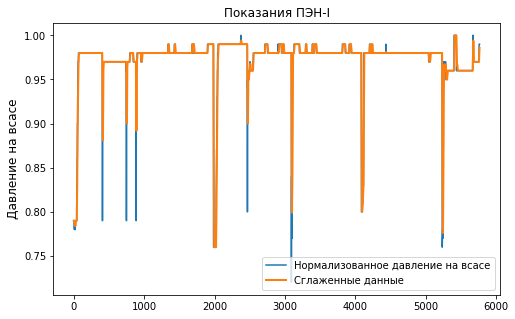

In [66]:
fig4 = plt.figure(figsize=(8, 5))
ax4 = fig4.add_subplot(111)

(filtred_data['pump_1_in']/filtred_data['pump_1_in'].max()).plot(title='Показания ПЭН-I', label="Нормализованное давление на всасе",axes=ax4)
smoothed_data['pump_1_in'].plot(linewidth=2, label="Сглаженные данные", axes=ax4)
plt.ylabel("Давление на всасе", fontsize=12)
ax4.legend(loc="lower right")


<h1>Центрирование</h1>

In [67]:
norm_pump_1_in = (smoothed_data['pump_1_in']-smoothed_data['pump_1_in'].mean())/smoothed_data['pump_1_in']
norm_pump_1_eff = (smoothed_data['pump_1_eff']-smoothed_data['pump_1_eff'].mean())/smoothed_data['pump_1_eff']

norm_pump_2_in = (smoothed_data['pump_2_in']-smoothed_data['pump_2_in'].mean())/smoothed_data['pump_2_in']
norm_pump_2_eff = (smoothed_data['pump_2_eff']-smoothed_data['pump_2_eff'].mean())/smoothed_data['pump_2_eff']

norm_pump_3_in = (smoothed_data['pump_3_in']-smoothed_data['pump_3_in'].mean())/smoothed_data['pump_3_in']
norm_pump_3_eff = (smoothed_data['pump_3_eff']-smoothed_data['pump_3_eff'].mean())/smoothed_data['pump_3_eff']

centred_data = {
    'pump_1_in': (smoothed_data['pump_1_in']-smoothed_data['pump_1_in'].mean())/smoothed_data['pump_1_in'],
    'pump_2_in': (smoothed_data['pump_2_in']-smoothed_data['pump_2_in'].mean())/smoothed_data['pump_2_in'],
    'pump_3_in': (smoothed_data['pump_3_in']-smoothed_data['pump_3_in'].mean())/smoothed_data['pump_3_in'],
    'pump_4_in': (smoothed_data['pump_4_in']-smoothed_data['pump_4_in'].mean())/smoothed_data['pump_4_in'],
    'pump_5_in': (smoothed_data['pump_5_in']-smoothed_data['pump_5_in'].mean())/smoothed_data['pump_5_in'],

    'pump_1_out': (smoothed_data['pump_1_out']-smoothed_data['pump_1_out'].mean())/smoothed_data['pump_1_out'],
    'pump_2_out': (smoothed_data['pump_2_out']-smoothed_data['pump_2_out'].mean())/smoothed_data['pump_2_out'],
    'pump_3_out': (smoothed_data['pump_3_out']-smoothed_data['pump_3_out'].mean())/smoothed_data['pump_3_out'],
    'pump_4_out': (smoothed_data['pump_4_out']-smoothed_data['pump_4_out'].mean())/smoothed_data['pump_4_out'],
    'pump_5_out': (smoothed_data['pump_5_out']-smoothed_data['pump_5_out'].mean())/smoothed_data['pump_5_out'],

    'pump_1_eff': (smoothed_data['pump_1_eff']-smoothed_data['pump_1_eff'].mean())/smoothed_data['pump_1_eff'],
    'pump_2_eff': (smoothed_data['pump_2_eff']-smoothed_data['pump_2_eff'].mean())/smoothed_data['pump_2_eff'],
    'pump_3_eff': (smoothed_data['pump_3_eff']-smoothed_data['pump_3_eff'].mean())/smoothed_data['pump_3_eff'],
    'pump_4_eff': (smoothed_data['pump_4_eff']-smoothed_data['pump_4_eff'].mean())/smoothed_data['pump_4_eff'],
    'pump_5_eff': (smoothed_data['pump_5_eff']-smoothed_data['pump_5_eff'].mean())/smoothed_data['pump_5_eff'],
    
    'pump_1_temp': (smoothed_data['pump_1_temp']-smoothed_data['pump_1_temp'].mean())/smoothed_data['pump_1_temp'],
    'pump_2_temp': (smoothed_data['pump_2_temp']-smoothed_data['pump_2_temp'].mean())/smoothed_data['pump_2_temp'],
    'pump_3_temp': (smoothed_data['pump_3_temp']-smoothed_data['pump_3_temp'].mean())/smoothed_data['pump_3_temp'],
    'pump_4_temp': (smoothed_data['pump_4_temp']-smoothed_data['pump_4_temp'].mean())/smoothed_data['pump_4_temp'],
    'pump_5_temp': (smoothed_data['pump_5_temp']-smoothed_data['pump_5_temp'].mean())/smoothed_data['pump_5_temp'],

    'pump_1_revs': (smoothed_data['pump_1_revs']-smoothed_data['pump_1_revs'].mean())/smoothed_data['pump_1_revs'],
    'pump_2_revs': (smoothed_data['pump_2_revs']-smoothed_data['pump_2_revs'].mean())/smoothed_data['pump_2_revs'],
    'pump_3_revs': (smoothed_data['pump_3_revs']-smoothed_data['pump_3_revs'].mean())/smoothed_data['pump_3_revs'],
    'pump_4_revs': (smoothed_data['pump_4_revs']-smoothed_data['pump_4_revs'].mean())/smoothed_data['pump_4_revs'],
    'pump_5_revs': (smoothed_data['pump_5_revs']-smoothed_data['pump_5_revs'].mean())/smoothed_data['pump_5_revs'],

    'pump_1_amper': (smoothed_data['pump_1_amper']-smoothed_data['pump_1_amper'].mean())/smoothed_data['pump_1_amper'],
    'pump_2_amper': (smoothed_data['pump_2_amper']-smoothed_data['pump_2_amper'].mean())/smoothed_data['pump_2_amper'],
    'pump_3_amper': (smoothed_data['pump_3_amper']-smoothed_data['pump_3_amper'].mean())/smoothed_data['pump_3_amper'],
    'pump_4_amper': (smoothed_data['pump_4_amper']-smoothed_data['pump_4_amper'].mean())/smoothed_data['pump_4_amper'],
    'pump_5_amper': (smoothed_data['pump_5_amper']-smoothed_data['pump_5_amper'].mean())/smoothed_data['pump_5_amper'],
}

corr_coefs = [
    # p_in -- p_eff
    np.corrcoef(centred_data['pump_1_in'].to_numpy(), centred_data['pump_1_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_2_in'].to_numpy(), centred_data['pump_2_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_3_in'].to_numpy(), centred_data['pump_3_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_4_in'].to_numpy(), centred_data['pump_4_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_5_in'].to_numpy(), centred_data['pump_5_eff'].to_numpy()),

    # p_out -- p_eff
    np.corrcoef(centred_data['pump_1_out'].to_numpy(), centred_data['pump_1_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_2_out'].to_numpy(), centred_data['pump_2_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_3_out'].to_numpy(), centred_data['pump_3_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_4_out'].to_numpy(), centred_data['pump_4_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_5_out'].to_numpy(), centred_data['pump_5_eff'].to_numpy()),

    
    # p_temp -- p_eff
    np.corrcoef(centred_data['pump_1_temp'].to_numpy(), centred_data['pump_1_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_2_temp'].to_numpy(), centred_data['pump_2_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_3_temp'].to_numpy(), centred_data['pump_3_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_4_temp'].to_numpy(), centred_data['pump_4_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_5_temp'].to_numpy(), centred_data['pump_5_eff'].to_numpy()),    
    
    # p_I -- p_eff
    np.corrcoef(centred_data['pump_1_amper'].to_numpy(), centred_data['pump_1_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_2_amper'].to_numpy(), centred_data['pump_2_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_3_amper'].to_numpy(), centred_data['pump_3_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_4_amper'].to_numpy(), centred_data['pump_4_eff'].to_numpy()),
    np.corrcoef(centred_data['pump_5_amper'].to_numpy(), centred_data['pump_5_eff'].to_numpy()),    
]


for ind, coef in enumerate(corr_coefs):
    if ind % 5 == 0:
        print("---------------")
    print(coef[0][1])


---------------
0.6538888400805398
0.5560835924257299
0.5352020039236496
0.5041124489947797
0.3823648925481814
---------------
-0.6382530588550859
-0.5395059509278061
-0.5073684603094456
-0.2769953447859412
-0.446731672617566
---------------
0.6021718986086283
0.5655864925587453
0.439175035776968
0.5038893204625905
0.40990170085760474
---------------
0.6975658223942907
0.5572398365461594
0.2410000672015234
0.04728613712572036
0.5785429280542916


<h1>Линейная регрессия</h1>
<p>Одномерная для Pin/out-КПД, Tпв-КПД</p>
<p>Многомернаяя для Pin+Pout-КПД

<h5>Давление - КПД</h5>

R^2: 0.1995691873196883
MAE: 0.02305080305855044
RMSE: 0.07452765332271673
y = -2.177 + -0.003439


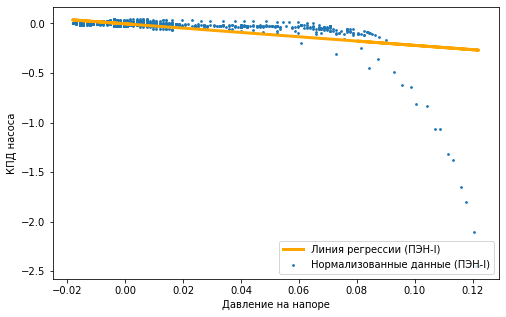

In [68]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

model1 = linear_model.LinearRegression()

x_test = centred_data['pump_5_out'].values.reshape(-1,1)
y_test = centred_data['pump_5_eff'].values.reshape(-1,1)


model1.fit(x_test, y_test)

y_pred = model1.predict(x_test)

fig51 = plt.figure(figsize=(8, 5))
ax51 = fig51.add_subplot(111)

ax51.scatter(x_test, y_test, s=3, label='Нормализованные данные (ПЭН-I)')
ax51.plot(x_test, y_pred, color='orange', linewidth=3, label='Линия регрессии (ПЭН-I)')
ax51.legend(loc="lower right")
ax51.set_ylabel("КПД насоса")
ax51.set_xlabel("Давление на напоре")



print("R^2:", model1.score(x_test, y_test))
print("MAE: {}".format(np.abs(y_test-y_pred).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-y_pred)**2).mean())))
print(f'y = {round(model1.coef_[0][0],4)} + {round(model1.intercept_[0],6)}')

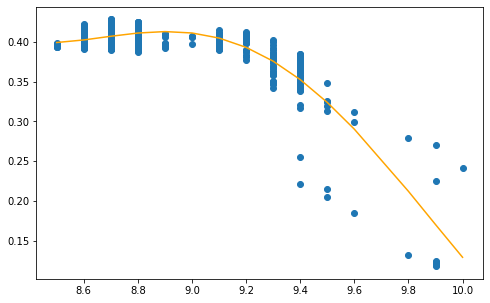

In [69]:
from sklearn.preprocessing import PolynomialFeatures 
nb_degree = 4
poly_reg = PolynomialFeatures(degree = nb_degree)

x = filtred_data['pump_2_out'].to_numpy()
y = filtred_data['pump_2_eff'].to_numpy()


y = y[x.argsort()]
x = x[x.argsort()]

x = x[:, np.newaxis]
y = y[:, np.newaxis]


X_TRANSF = poly_reg.fit_transform(x)

poly_reg.fit(X_TRANSF, y)

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_TRANSF, y)

fig511 = plt.figure(figsize=(8, 5))
ax511 = fig511.add_subplot(111)

ax511.scatter(x, y)
ax511.plot(x,lin_reg.predict(X_TRANSF), color='orange')


<h5>Температура пит. воды - КПД </h5>

R^2: 0.1680194043659572
MAE: 0.021027113005316855
RMSE: 0.07598224934560963
y = 2.649 + -0.002343


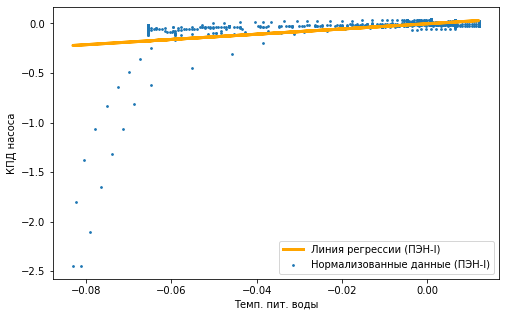

In [70]:
model2 = linear_model.LinearRegression()

x_test = centred_data['pump_5_temp'].values.reshape(-1,1)
y_test = centred_data['pump_5_eff'].values.reshape(-1,1)


model2.fit(x_test, y_test)

y_pred = model2.predict(x_test)

fig52 = plt.figure(figsize=(8, 5))
ax52 = fig52.add_subplot(111)

ax52.scatter(x_test, y_test, s=3, label='Нормализованные данные (ПЭН-I)')
ax52.plot(x_test, y_pred, color='orange', linewidth=3, label='Линия регрессии (ПЭН-I)')
ax52.legend(loc="lower right")
ax52.set_ylabel("КПД насоса")
ax52.set_xlabel("Темп. пит. воды")

print("R^2:", model2.score(x_test, y_test))
print("MAE: {}".format(np.abs(y_test-y_pred).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-y_pred)**2).mean())))
print(f'y = {round(model2.coef_[0][0],4)} + {round(model2.intercept_[0],6)}')


<h5>Многомерная регрессия</h5>

R^2: 0.3418427614765174
MAE: 0.005315020579435241
RMSE: 0.009163338412245202


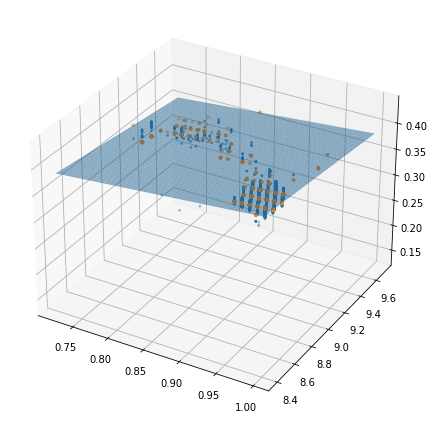

In [71]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

model3 = linear_model.LinearRegression()

reg_df = pd.DataFrame(
    {
        'pump_1_in':filtred_df['pump_1_in'],
        'pump_1_out':filtred_df['pump_1_out'],
        'pump_1_eff':filtred_df['pump_1_eff'],
    }
)

x_test = reg_df[['pump_1_in', 'pump_1_out']]
y_test = reg_df['pump_1_eff']

model3.fit(x_test, y_test)

y_pred = model3.predict(x_test)


score = model3.score(x_test, y_test)

reg_df = pd.DataFrame(
    {
        'pump_1_in':filtred_df['pump_1_in'],
        'pump_1_out':filtred_df['pump_1_out'],
#         'pump_1_eff':filtred_df['pump_1_eff'],
    }
)

x = reg_df[['pump_1_in', 'pump_1_out']].values
y = filtred_df['pump_1_eff'].to_numpy()


fig6 = plt.figure(figsize=(25, 10))
ax6 = fig6.add_subplot(131, projection='3d')

ax6.scatter(x[:,0], x[:,1], y, s=3)
ax6.scatter(x[:,0], x[:,1], y_pred, s=8)

print("R^2:", score)
print("MAE: {}".format(np.abs(y_test-y_pred).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-y_pred)**2).mean())))


coefs = model3.coef_
intercept = model3.intercept_

import math
n = (x[:,0].max()-x[:,0].min())/0.01
m = (x[:,1].max()-x[:,1].min())/0.01

n = math.ceil(n)
m = math.ceil(m)

# xs = np.tile(np.arange(x[:,0].min(),x[:,0].max(), 0.01), (n,1))
# ys = np.tile(np.arange(x[:,1].min(),x[:,1].max(), 0.01), (m,1)).T

xs = np.linspace(x[:,0].min(), x[:,0].max(), 50)
ys = np.linspace(x[:,1].min(), x[:,1].max(), 50)

xs, ys = np.meshgrid(xs,ys)

zs = xs*coefs[0]+ys*coefs[1]+intercept

ax6.plot_surface(xs,ys,zs, alpha=0.5)
plt.show()

<h5>Попарные коэф. корреляции</h5>

In [72]:
# # df.rename(columns={
# #     pump_in_cols[0]: "pump_1_in",
# #     pump_in_cols[1]: "pump_2_in",
# #     pump_in_cols[2]: "pump_3_in",
# #     pump_in_cols[3]: "pump_4_in",
# #     pump_in_cols[4]: "pump_5_in",
    
# #     pump_out_cols[0]: "pump_1_out",
# #     pump_out_cols[1]: "pump_2_out",
# #     pump_out_cols[2]: "pump_3_out",
# #     pump_out_cols[3]: "pump_4_out",
# #     pump_out_cols[4]: "pump_5_out",
    
# #     pump_mass_cols[0]: "pump_1_mass",
# #     pump_mass_cols[1]: "pump_2_mass",
# #     pump_mass_cols[2]: "pump_3_mass",
# #     pump_mass_cols[3]: "pump_4_mass",
# #     pump_mass_cols[4]: "pump_5_mass",
    
# #     pump_temp_col: "temp",
    
# #     pump_amper_cols[0]: "pump_1_amper",
# #     pump_amper_cols[1]: "pump_2_amper",
# #     pump_amper_cols[2]: "pump_3_amper",
# #     pump_amper_cols[3]: "pump_4_amper",
# #     pump_amper_cols[4]: "pump_5_amper",
    
# #     pump_revs_cols[0]: "pump_1_revs",
# #     pump_revs_cols[1]: "pump_2_revs",
# #     pump_revs_cols[2]: "pump_3_revs",
# #     pump_revs_cols[3]: "pump_4_revs",
# #     pump_revs_cols[4]: "pump_5_revs",
    
# #     pump_volt_cols[0]: "pump_1_volt",
# #     pump_volt_cols[1]: "pump_2_volt",
# #     pump_volt_cols[2]: "pump_3_volt",
# #     pump_volt_cols[3]: "pump_4_volt",
    
# #     pump_turbine_col: "pump_turbine",
# #     pump_reactor_col: "pump_reactor",
# # }, inplace = True)

# df.rename(columns={
#     pump_in_cols[0]: "ПЭН-1 Pнап",
#     pump_in_cols[1]: "ПЭН-2 Pнап",
#     pump_in_cols[2]: "ПЭН-3 Pнап",
#     pump_in_cols[3]: "ПЭН-4 Pнап",
#     pump_in_cols[4]: "ПЭН-5 Pнап",
    
#     pump_out_cols[0]: "ПЭН-1 Pвсас",
#     pump_out_cols[1]: "ПЭН-2 Pвсас",
#     pump_out_cols[2]: "ПЭН-3 Pвсас",
#     pump_out_cols[3]: "ПЭН-4 Pвсас",
#     pump_out_cols[4]: "ПЭН-5 Pвсас",
    
#     pump_mass_cols[0]: "ПЭН-1 Расход",
#     pump_mass_cols[1]: "ПЭН-2 Расход",
#     pump_mass_cols[2]: "ПЭН-3 Расход",
#     pump_mass_cols[3]: "ПЭН-4 Расход",
#     pump_mass_cols[4]: "ПЭН-5 Расход",
    
#     pump_temp_col: "Tпит.в",
    
#     pump_amper_cols[0]: "ПЭН-1 Сила тока",
#     pump_amper_cols[1]: "ПЭН-2 Сила тока",
#     pump_amper_cols[2]: "ПЭН-3 Сила тока",
#     pump_amper_cols[3]: "ПЭН-4 Сила тока",
#     pump_amper_cols[4]: "ПЭН-5 Сила тока",
    
#     pump_revs_cols[0]: "ПЭН-1 Част.вр.эл.дв.",
#     pump_revs_cols[1]: "ПЭН-2 Част.вр.эл.дв.",
#     pump_revs_cols[2]: "ПЭН-3 Част.вр.эл.дв.",
#     pump_revs_cols[3]: "ПЭН-4 Част.вр.эл.дв.",
#     pump_revs_cols[4]: "ПЭН-5 Част.вр.эл.дв.",
    
#     pump_volt_cols[0]: "Напряж. секц.BBA",
#     pump_volt_cols[1]: "Напряж. секц.BBB",
#     pump_volt_cols[2]: "Напряж. секц.BBC",
#     pump_volt_cols[3]: "Напряж. секц.BBD",
    
#     pump_turbine_col: "Мощность турб",
#     pump_reactor_col: "Мощность реакт",
# }, inplace = True)


# df.corr()

<h1>Нейросети</h1>

<p>Обучение на данных первого насоса</p>
<p>Выход - КПД, входы - давления, расход, темп, обороты, ток</p>

In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
#   plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Ошибка по модулю')  
  plt.plot(hist['epoch'], hist['mae'],
           label='Среднеквадратичная ошибка')
  plt.ylim([0,0.06])

<h3>Обучение с применением функции ReLU</h3>

In [18]:
def build_and_train(pump_num, EPOCHS=3500, patience=500):
    pump_filtred_df = pd.DataFrame({
        'pump_in': filtred_data[f'pump_{pump_num}_in'],
        'pump_out': filtred_data[f'pump_{pump_num}_out'],
        'pump_mass': filtred_data[f'pump_{pump_num}_mass'],
        'pump_temp': filtred_data[f'pump_{pump_num}_temp'],
        'pump_revs': filtred_data[f'pump_{pump_num}_revs'],
        'pump_amper': filtred_data[f'pump_{pump_num}_amper'],
        'pump_eff': filtred_data[f'pump_{pump_num}_eff'],
    })

    train_dataset = pump_filtred_df.sample(frac=0.8,random_state=0)
    test_dataset = pump_filtred_df.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop("pump_eff")
    train_stats = train_stats.transpose()

    train_labels = train_dataset.pop('pump_eff')
    test_labels = test_dataset.pop('pump_eff')

    def norm(x):
      return (x - train_stats['mean']) / train_stats['std']

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)


    def build_model():
      model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
      ])

      optimizer = tf.keras.optimizers.RMSprop(0.001)

      model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
      return model

    model = build_model()
    model.summary()

    example_batch = normed_train_data[:10]
    example_result = model.predict(example_batch)

    model = build_model()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            print(f"\rProgress: {epoch}/{EPOCHS} {logs}", end='')

    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    plot_history(history)

    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

    print("Testing set MAE: {:5.5f}, MSE: {:5.5f}".format(mae, mse))

    test_predictions = model.predict(normed_test_data).flatten()
    fig8 = plt.figure(figsize=(30, 5))
    ax8 = fig8.add_subplot(131)
    ax8.plot(test_predictions, color='blue', label='Предсказанное значение')
    ax8.plot(test_labels.reset_index()['pump_eff'], color='orange', label='Фактическое значение')
    ax8.set_ylabel(f'КПД ПЭН-{pump_num}')
    ax8.legend(loc='lower right')
    
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
37/37 - 0s - loss: 1.2046e-05 - mae: 0.0025 - mse: 1.2046e-05.001622554613277316, 'mse': 5.4980264394544065e-06, 'val_loss': 1.1656770766421687e-05, 'val_mae': 0.002433257643133402, 'val_mse': 1.1656770766421687e-05}5}
Testing set Mean Abs Error: 0.00253


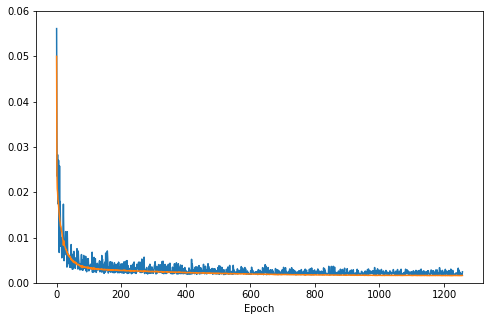

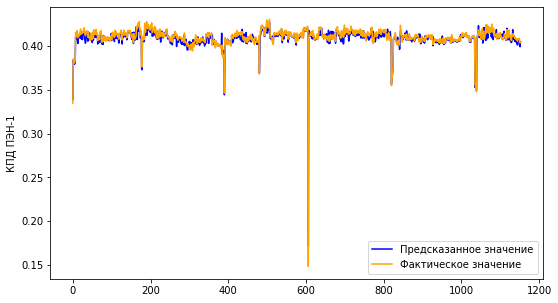

In [19]:
build_and_train(1) # обучение ПЭН-I

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
26/26 - 0s - loss: 7.6489e-06 - mae: 0.0021 - mse: 7.6489e-06
Testing set Mean Abs Error: 0.00209


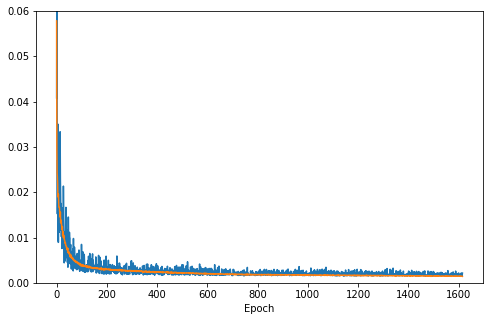

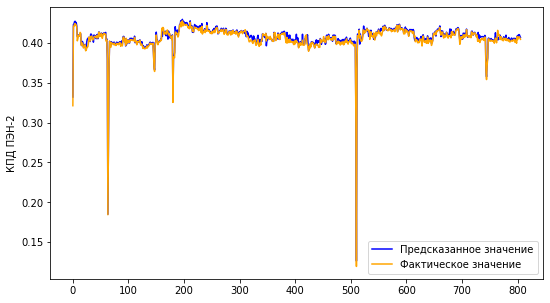

In [20]:
build_and_train(2) # обучение ПЭН-II

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
25/25 - 0s - loss: 8.3889e-06 - mae: 0.0018 - mse: 8.3889e-060017647927161306143, 'mse': 6.830322035966674e-06, 'val_loss': 8.117490324366372e-06, 'val_mae': 0.0017129421466961503, 'val_mse': 8.117491233861074e-06}6}}}
Testing set Mean Abs Error: 0.00184


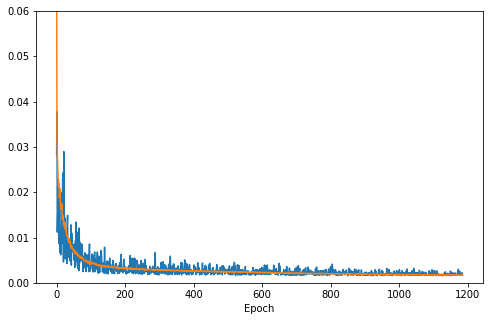

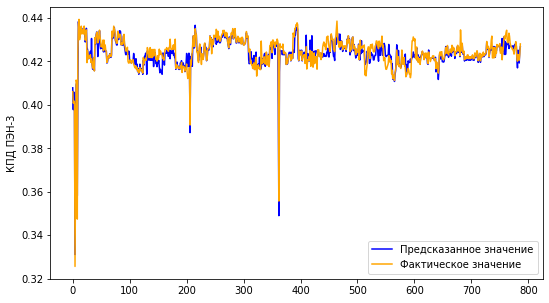

In [21]:
build_and_train(3) # обучение ПЭН-III

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
30/30 - 0s - loss: 8.8192e-06 - mae: 0.0018 - mse: 8.8192e-06001592702348716557, 'mse': 5.517849331226898e-06, 'val_loss': 1.2103169865440577e-05, 'val_mae': 0.001836547628045082, 'val_mse': 1.2103169865440577e-05}5}}}
Testing set Mean Abs Error: 0.00176


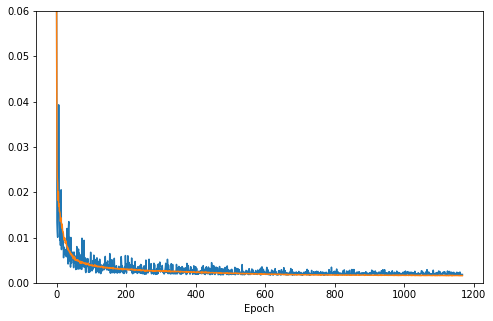

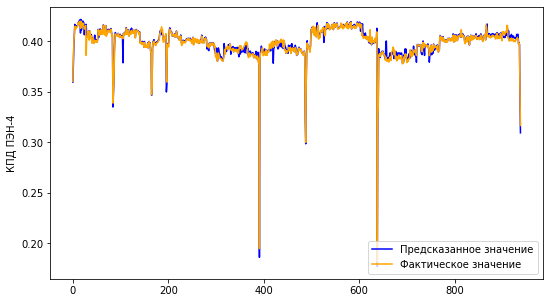

In [22]:
build_and_train(4) # обучение ПЭН-IV

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
30/30 - 0s - loss: 8.1793e-06 - mae: 0.0020 - mse: 8.1793e-06001976741012185812, 'mse': 7.741370609437581e-06, 'val_loss': 8.747010724619031e-06, 'val_mae': 0.0020577055402100086, 'val_mse': 8.747010724619031e-06}05}}
Testing set Mean Abs Error: 0.00200


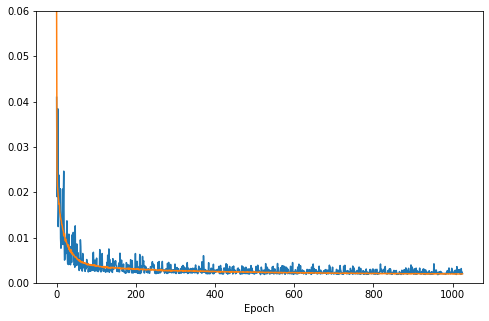

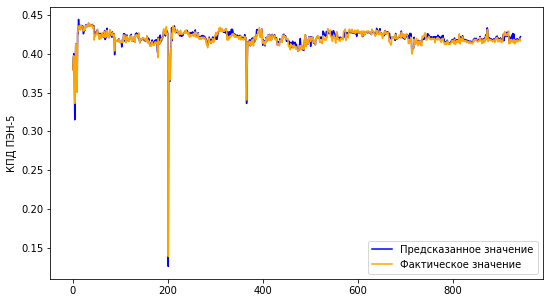

In [23]:
build_and_train(5) # обучение ПЭН-V

<h3>Обучение с активационной функцией Sigmoid</h3>

In [24]:
def build_and_train(pump_num, EPOCHS=3500, patience=500):
    pump_filtred_df = pd.DataFrame({
        'pump_in': filtred_data[f'pump_{pump_num}_in'],
        'pump_out': filtred_data[f'pump_{pump_num}_out'],
        'pump_mass': filtred_data[f'pump_{pump_num}_mass'],
        'pump_temp': filtred_data[f'pump_{pump_num}_temp'],
        'pump_revs': filtred_data[f'pump_{pump_num}_revs'],
        'pump_amper': filtred_data[f'pump_{pump_num}_amper'],
        'pump_eff': filtred_data[f'pump_{pump_num}_eff'],
    })

    train_dataset = pump_filtred_df.sample(frac=0.8,random_state=0)
    test_dataset = pump_filtred_df.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop("pump_eff")
    train_stats = train_stats.transpose()

    train_labels = train_dataset.pop('pump_eff')
    test_labels = test_dataset.pop('pump_eff')

    def norm(x):
      return (x - train_stats['mean']) / train_stats['std']

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)


    def build_model():
      model = keras.Sequential([
        layers.Dense(64, activation='sigmoid', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='sigmoid'),
        layers.Dense(1)
      ])

      optimizer = tf.keras.optimizers.RMSprop(0.001)

      model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
      return model

    model = build_model()
    model.summary()

    example_batch = normed_train_data[:10]
    example_result = model.predict(example_batch)

    model = build_model()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            print(f"\rProgress: {epoch}/{EPOCHS} {logs}", end='')

    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    plot_history(history)

    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

    print("Testing set MAE: {:5.5f}, MSE: {:5.5f}".format(mae, mse))

    test_predictions = model.predict(normed_test_data).flatten()
    fig8 = plt.figure(figsize=(30, 5))
    ax8 = fig8.add_subplot(131)
    ax8.plot(test_predictions, color='blue', label='Предсказанное значение')
    ax8.plot(test_labels.reset_index()['pump_eff'], color='orange', label='Фактическое значение')
    ax8.set_ylabel(f'КПД ПЭН-{pump_num}')
    ax8.legend(loc='lower right')
    
    

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
37/37 - 0s - loss: 6.4885e-05 - mae: 0.0074 - mse: 6.4885e-0500409775460138917, 'mse': 2.421089811832644e-05, 'val_loss': 6.801504787290469e-05, 'val_mae': 0.007467574905604124, 'val_mse': 6.801504787290469e-05}e-05}}}
Testing set Mean Abs Error: 0.00741


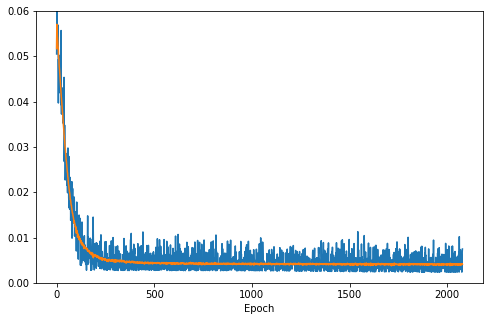

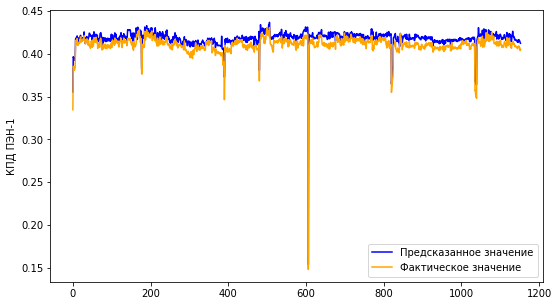

In [25]:
build_and_train(1) # обучение ПЭН-I

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
26/26 - 0s - loss: 8.6126e-06 - mae: 0.0022 - mse: 8.6126e-06
Testing set Mean Abs Error: 0.00221


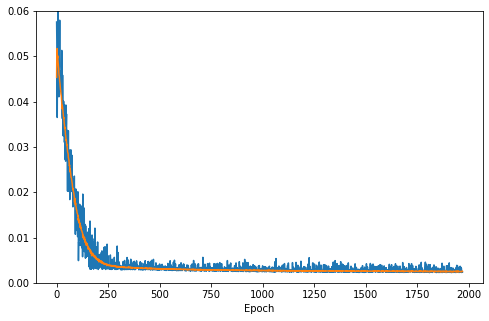

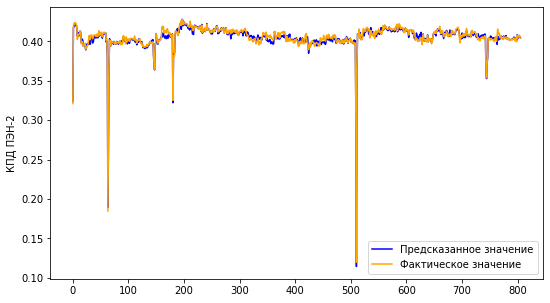

In [26]:
build_and_train(2) # обучение ПЭН-II

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
25/25 - 0s - loss: 3.4114e-05 - mae: 0.0051 - mse: 3.4114e-05
Testing set Mean Abs Error: 0.00507


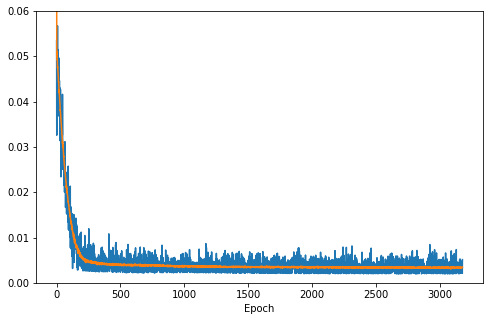

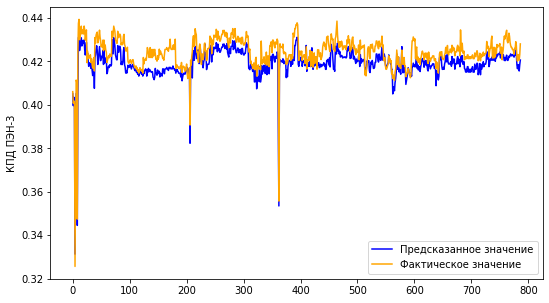

In [27]:
build_and_train(3) # обучение ПЭН-III

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
30/30 - 0s - loss: 2.0438e-05 - mae: 0.0036 - mse: 2.0438e-055960193928331137, 'mse': 4.91344508191105e-05, 'val_loss': 3.083642150158994e-05, 'val_mae': 0.003782972926273942, 'val_mse': 3.083642150158994e-05}05}}}5}}
Testing set Mean Abs Error: 0.00363


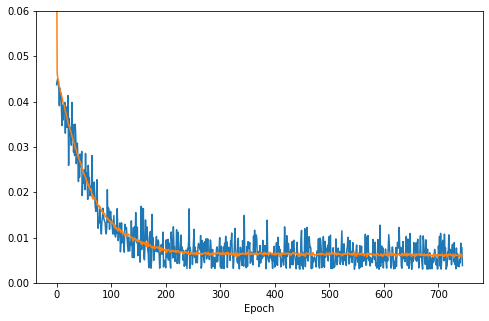

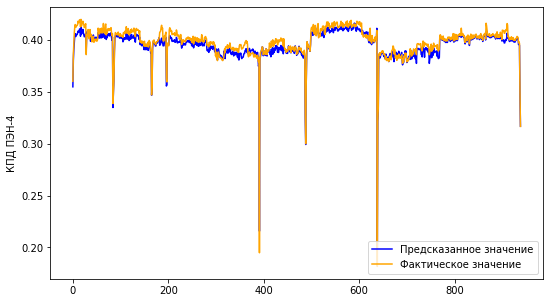

In [28]:
build_and_train(4) # обучение ПЭН-IV

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_55 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
30/30 - 0s - loss: 9.7771e-06 - mae: 0.0024 - mse: 9.7771e-06004998724441975355, 'mse': 3.389253470231779e-05, 'val_loss': 1.036616140481783e-05, 'val_mae': 0.0024801630061119795, 'val_mse': 1.036616140481783e-05}}}5}}
Testing set Mean Abs Error: 0.00241


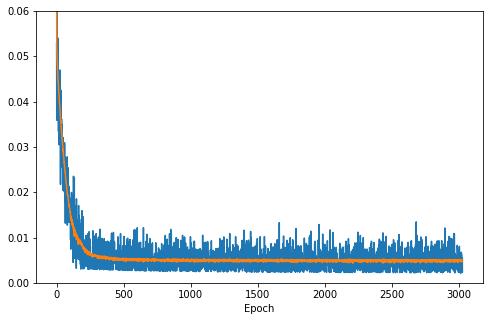

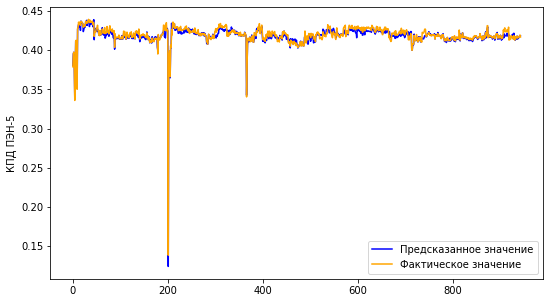

In [29]:
build_and_train(5) # обучение ПЭН-V

<h3>Обучение с активационной функцией tanh</h3>

In [30]:
def build_and_train(pump_num, EPOCHS=3500, patience=500):
    pump_filtred_df = pd.DataFrame({
        'pump_in': filtred_data[f'pump_{pump_num}_in'],
        'pump_out': filtred_data[f'pump_{pump_num}_out'],
        'pump_mass': filtred_data[f'pump_{pump_num}_mass'],
        'pump_temp': filtred_data[f'pump_{pump_num}_temp'],
        'pump_revs': filtred_data[f'pump_{pump_num}_revs'],
        'pump_amper': filtred_data[f'pump_{pump_num}_amper'],
        'pump_eff': filtred_data[f'pump_{pump_num}_eff'],
    })

    train_dataset = pump_filtred_df.sample(frac=0.8,random_state=0)
    test_dataset = pump_filtred_df.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop("pump_eff")
    train_stats = train_stats.transpose()

    train_labels = train_dataset.pop('pump_eff')
    test_labels = test_dataset.pop('pump_eff')

    def norm(x):
      return (x - train_stats['mean']) / train_stats['std']

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)


    def build_model():
      model = keras.Sequential([
        layers.Dense(64, activation='tanh', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1)
      ])

      optimizer = tf.keras.optimizers.RMSprop(0.001)

      model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
      return model

    model = build_model()
    model.summary()

    example_batch = normed_train_data[:10]
    example_result = model.predict(example_batch)

    model = build_model()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            print(f"\rProgress: {epoch}/{EPOCHS} {logs}", end='')

    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    plot_history(history)

    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

    print("Testing set MAE: {:5.5f}, MSE: {:5.5f}".format(mae, mse))

    test_predictions = model.predict(normed_test_data).flatten()
    fig8 = plt.figure(figsize=(30, 5))
    ax8 = fig8.add_subplot(131)
    ax8.plot(test_predictions, color='blue', label='Предсказанное значение')
    ax8.plot(test_labels.reset_index()['pump_eff'], color='orange', label='Фактическое значение')
    ax8.set_ylabel(f'КПД ПЭН-{pump_num}')
    ax8.legend(loc='lower right')
    
    

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_61 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
37/37 - 0s - loss: 2.1172e-05 - mae: 0.0037 - mse: 2.1172e-05.0028202910907566547, 'mse': 1.2756268006341998e-05, 'val_loss': 2.229324854852166e-05, 'val_mae': 0.003692570375278592, 'val_mse': 2.229324854852166e-05}}5}
Testing set Mean Abs Error: 0.00366


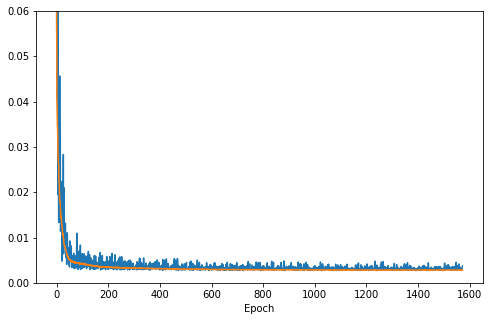

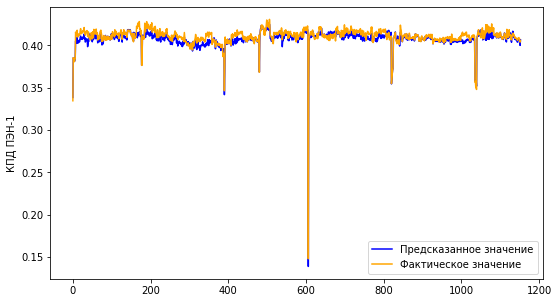

In [31]:
build_and_train(1) # обучение ПЭН-I

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
26/26 - 0s - loss: 1.8511e-05 - mae: 0.0033 - mse: 1.8511e-05.002805684693157673, 'mse': 1.2517270079115406e-05, 'val_loss': 1.8987317162100226e-05, 'val_mae': 0.003357422538101673, 'val_mse': 1.8987317162100226e-05}}}
Testing set Mean Abs Error: 0.00333


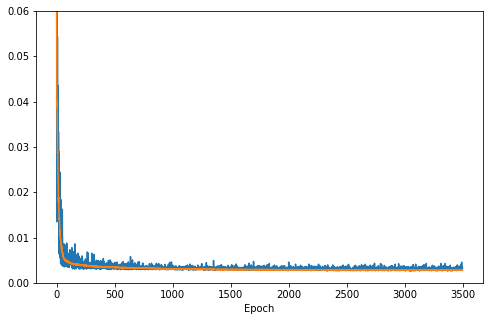

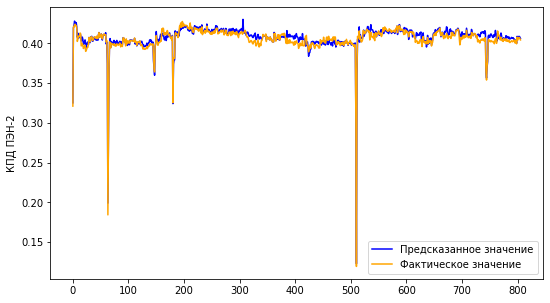

In [32]:
build_and_train(2) # обучение ПЭН-II

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_73 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
25/25 - 0s - loss: 1.6235e-05 - mae: 0.0032 - mse: 1.6235e-05
Testing set Mean Abs Error: 0.00317


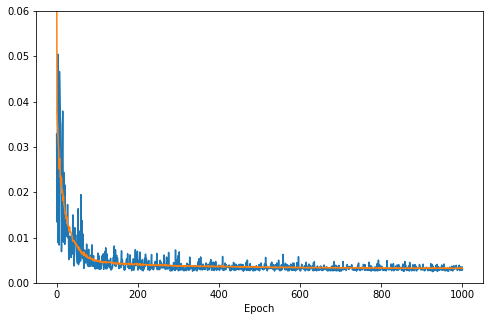

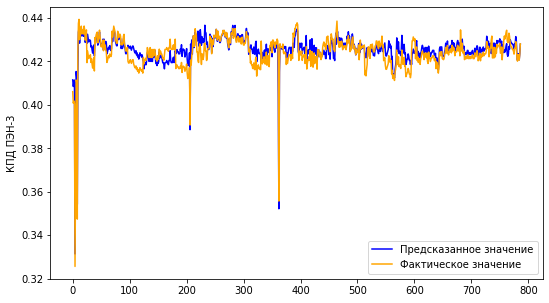

In [33]:
build_and_train(3) # обучение ПЭН-III

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
30/30 - 0s - loss: 1.3388e-05 - mae: 0.0028 - mse: 1.3388e-0503084278665482998, 'mse': 1.495590913691558e-05, 'val_loss': 2.7318272259435616e-05, 'val_mae': 0.003087759716436267, 'val_mse': 2.7318272259435616e-05}}5}}
Testing set Mean Abs Error: 0.00281


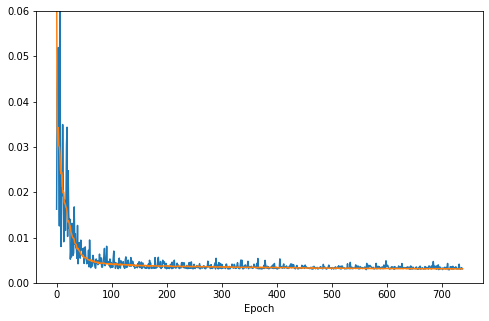

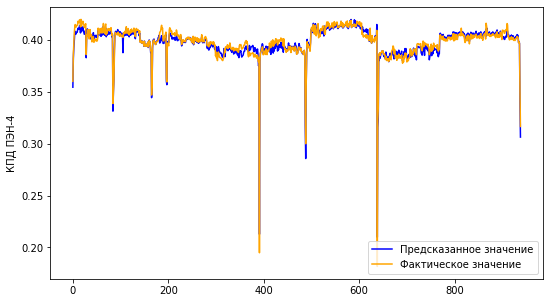

In [34]:
build_and_train(4) # обучение ПЭН-IV

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_85 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
30/30 - 0s - loss: 1.2241e-05 - mae: 0.0028 - mse: 1.2241e-05.0029085606802254915, 'mse': 1.3530413525586482e-05, 'val_loss': 1.213029281643685e-05, 'val_mae': 0.002815123414620757, 'val_mse': 1.213029281643685e-05}5}}
Testing set Mean Abs Error: 0.00284


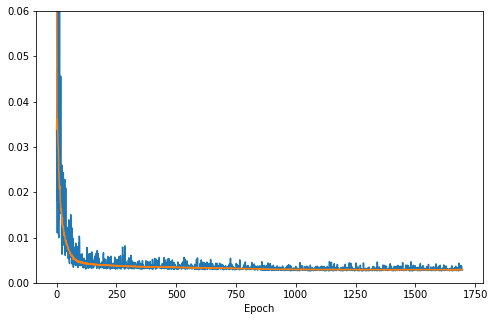

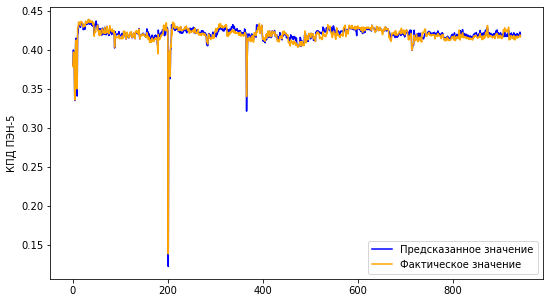

In [35]:
build_and_train(5) # обучение ПЭН-V

<h3>Обучение с использование LeakyReLU</h3>

In [36]:
from tensorflow.keras.layers import LeakyReLU

def build_and_train(pump_num, EPOCHS=3500, patience=500):
    pump_filtred_df = pd.DataFrame({
        'pump_in': filtred_data[f'pump_{pump_num}_in'],
        'pump_out': filtred_data[f'pump_{pump_num}_out'],
        'pump_mass': filtred_data[f'pump_{pump_num}_mass'],
        'pump_temp': filtred_data[f'pump_{pump_num}_temp'],
        'pump_revs': filtred_data[f'pump_{pump_num}_revs'],
        'pump_amper': filtred_data[f'pump_{pump_num}_amper'],
        'pump_eff': filtred_data[f'pump_{pump_num}_eff'],
    })

    train_dataset = pump_filtred_df.sample(frac=0.8,random_state=0)
    test_dataset = pump_filtred_df.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop("pump_eff")
    train_stats = train_stats.transpose()

    train_labels = train_dataset.pop('pump_eff')
    test_labels = test_dataset.pop('pump_eff')

    def norm(x):
      return (x - train_stats['mean']) / train_stats['std']

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)


    def build_model():
      model = keras.Sequential([
        LeakyReLU(alpha=0.1, input_shape=[len(train_dataset.keys())]),
        LeakyReLU(alpha=0.1),
        layers.Dense(1)
      ])

      optimizer = tf.keras.optimizers.RMSprop(0.001)

      model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
      return model

    model = build_model()
    model.summary()

    example_batch = normed_train_data[:10]
    example_result = model.predict(example_batch)

    model = build_model()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            print(f"\rProgress: {epoch}/{EPOCHS} {logs}", end='')
    
    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    plot_history(history)

    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

    print("Testing set MAE: {:5.5f}, MSE: {:5.5f}".format(mae, mse))

    test_predictions = model.predict(normed_test_data).flatten()
    fig8 = plt.figure(figsize=(30, 5))
    ax8 = fig8.add_subplot(131)
    ax8.plot(test_predictions, color='blue', label='Предсказанное значение')
    ax8.plot(test_labels.reset_index()['pump_eff'], color='orange', label='Фактическое значение')
    ax8.set_ylabel(f'КПД ПЭН-{pump_num}')
    ax8.legend(loc='lower right')
    
    

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu (LeakyReLU)      (None, 6)                 0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
37/37 - 0s - loss: 8.2925e-05 - mae: 0.0051 - mse: 8.2925e-05004871015436947346, 'mse': 6.845772441010922e-05, 'val_loss': 0.00011145456664962694, 'val_mae': 0.005018691066652536, 'val_mse': 0.00011145456664962694}}}
Testing set Mean Abs Error: 0.00509


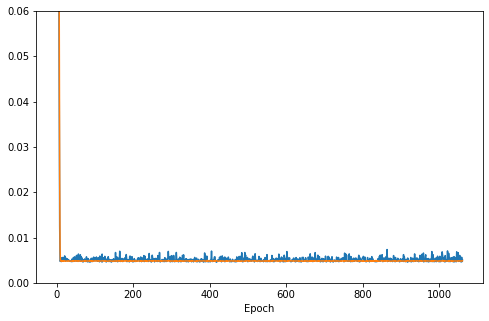

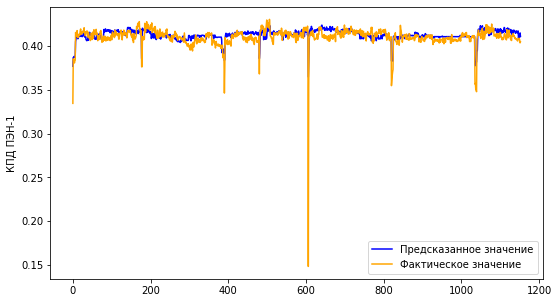

In [37]:
build_and_train(1) # обучение ПЭН-I

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu_4 (LeakyReLU)    (None, 6)                 0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6)                 0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
26/26 - 0s - loss: 1.5169e-04 - mae: 0.0066 - mse: 1.5169e-04006674622185528278, 'mse': 0.00015854636149015278, 'val_loss': 0.00021782492694910616, 'val_mae': 0.006933700293302536, 'val_mse': 0.00021782492694910616}}}
Testing set Mean Abs Error: 0.00665


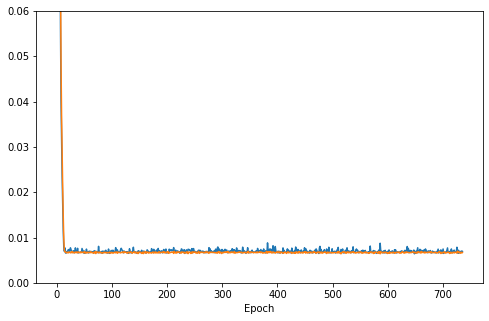

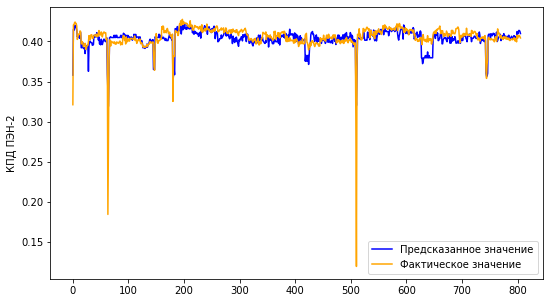

In [38]:
build_and_train(2) # обучение ПЭН-Ii

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu_8 (LeakyReLU)    (None, 6)                 0         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6)                 0         
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
25/25 - 0s - loss: 4.0937e-05 - mae: 0.0044 - mse: 4.0937e-0504795769229531288, 'mse': 9.83766294666566e-05, 'val_loss': 3.1120318453758955e-05, 'val_mae': 0.0040855733677744865, 'val_mse': 3.1120318453758955e-05}05}
Testing set Mean Abs Error: 0.00442


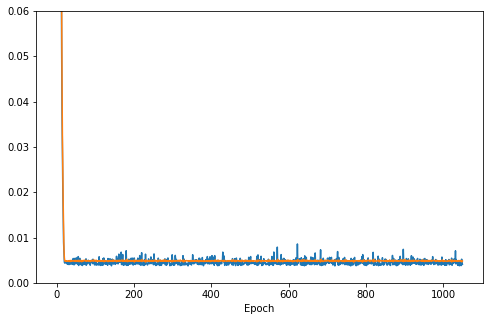

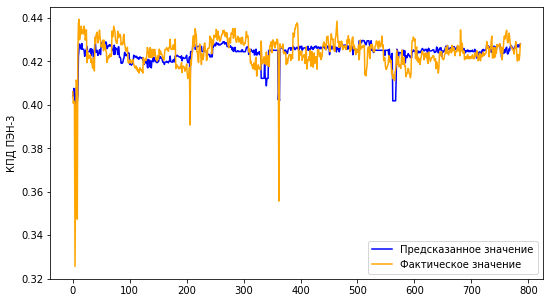

In [39]:
build_and_train(3) # обучение ПЭН-III

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu_12 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
30/30 - 0s - loss: 1.3411e-04 - mae: 0.0065 - mse: 1.3411e-04.006218705326318741, 'mse': 0.00010101077350554988, 'val_loss': 0.00011191188968950883, 'val_mae': 0.005884847603738308, 'val_mse': 0.00011191188968950883}}
Testing set Mean Abs Error: 0.00654


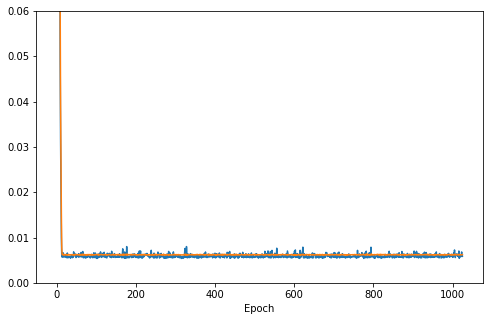

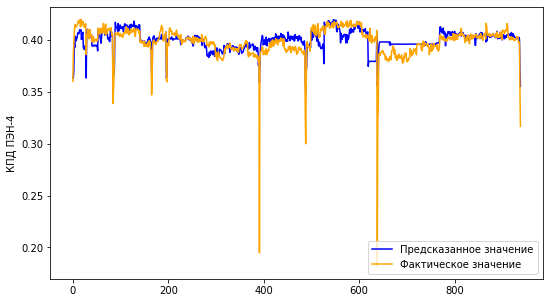

In [40]:
build_and_train(4) # обучение ПЭН-IV

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
leaky_re_lu_16 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
dense_98 (Dense)             (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
30/30 - 0s - loss: 1.0737e-04 - mae: 0.0056 - mse: 1.0737e-0400586524186655879, 'mse': 0.00021125659986864775, 'val_loss': 0.0002616560959722847, 'val_mae': 0.006753974128514528, 'val_mse': 0.0002616560959722847}96}}}
Testing set Mean Abs Error: 0.00563


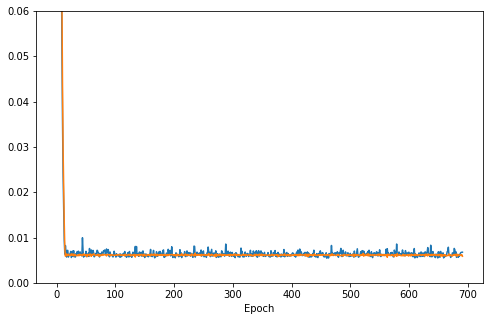

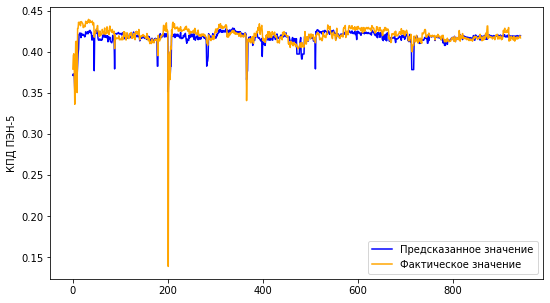

In [41]:
build_and_train(5) # обучение ПЭН-V

<h3>Обучение с применением функции Softmax</h3>

In [74]:
def build_and_train(pump_num, EPOCHS=3500, patience=500):
    pump_filtred_df = pd.DataFrame({
        'pump_in': filtred_data[f'pump_{pump_num}_in'],
        'pump_out': filtred_data[f'pump_{pump_num}_out'],
        'pump_mass': filtred_data[f'pump_{pump_num}_mass'],
        'pump_temp': filtred_data[f'pump_{pump_num}_temp'],
        'pump_revs': filtred_data[f'pump_{pump_num}_revs'],
        'pump_amper': filtred_data[f'pump_{pump_num}_amper'],
        'pump_eff': filtred_data[f'pump_{pump_num}_eff'],
    })

    train_dataset = pump_filtred_df.sample(frac=0.8,random_state=0)
    test_dataset = pump_filtred_df.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop("pump_eff")
    train_stats = train_stats.transpose()

    train_labels = train_dataset.pop('pump_eff')
    test_labels = test_dataset.pop('pump_eff')

    def norm(x):
      return (x - train_stats['mean']) / train_stats['std']

    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)


    def build_model():
      model = keras.Sequential([
        layers.Dense(64, activation='softmax', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='softmax'),
        layers.Dense(1)
      ])

      optimizer = tf.keras.optimizers.RMSprop(0.001)

      model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
      return model

    model = build_model()
    model.summary()

    example_batch = normed_train_data[:10]
    example_result = model.predict(example_batch)

    model = build_model()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            print(f"\rProgress: {epoch}/{EPOCHS} {logs}", end='')
    
    history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

    plot_history(history)

    loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

    print("Testing set MAE: {:5.5f}, MSE: {:5.5f}".format(mae, mse))

    test_predictions = model.predict(normed_test_data).flatten()
    fig8 = plt.figure(figsize=(30, 5))
    ax8 = fig8.add_subplot(131)
    ax8.plot(test_predictions, color='blue', label='Предсказанное значение')
    ax8.plot(test_labels.reset_index()['pump_eff'], color='orange', label='Фактическое значение')
    ax8.set_ylabel(f'КПД ПЭН-{pump_num}')
    ax8.legend(loc='lower right')
    
    

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_184 (Dense)            (None, 64)                448       
_________________________________________________________________
dense_185 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_186 (Dense)            (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Progress: 851/3500 {'loss': 9.765532922756393e-06, 'mae': 0.0024249034468084574, 'mse': 9.765532922756393e-06, 'val_loss': 2.0862278688582592e-05, 'val_mae': 0.0030706089455634356, 'val_mse': 2.0862278688582592e-05}}}37/37 - 0s - loss: 1.4433e-05 - mae: 0.0030 - mse: 1.4433e-05
Testing set MAE: 0.00301, MSE: 0.00001


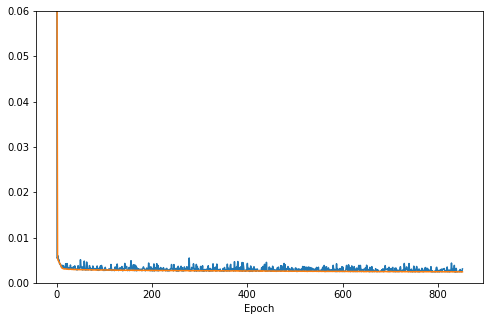

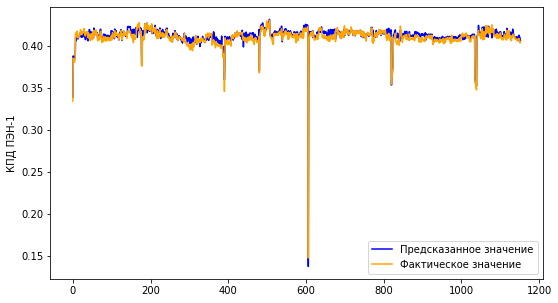

In [81]:
build_and_train(1) # обучение ПЭН-I

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 64)                448       
_________________________________________________________________
dense_161 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Progress: 3499/3500 {'loss': 8.32638397696428e-06, 'mae': 0.002192206447944045, 'mse': 8.32638397696428e-06, 'val_loss': 8.480797987431288e-06, 'val_mae': 0.0021604779176414013, 'val_mse': 8.480797987431288e-06}-05}}}}26/26 - 0s - loss: 8.3218e-06 - mae: 0.0021 - mse: 8.3218e-06
Testing set MAE: 0.00207, MSE: 0.00001


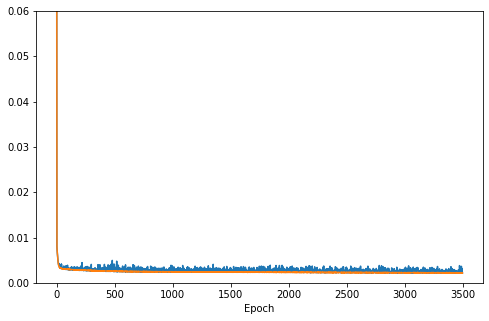

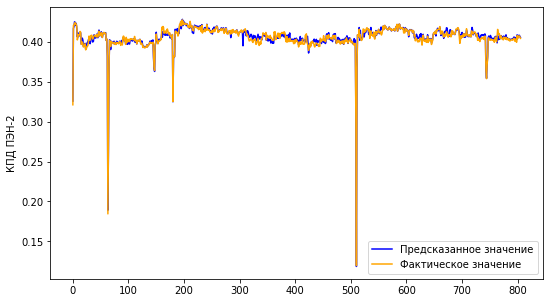

In [76]:
build_and_train(2) # обучение ПЭН-II

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 64)                448       
_________________________________________________________________
dense_167 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Progress: 1818/3500 {'loss': 8.960677405411843e-06, 'mae': 0.0022497568279504776, 'mse': 8.960677405411843e-06, 'val_loss': 8.970958333520684e-06, 'val_mae': 0.0019999686628580093, 'val_mse': 8.970958333520684e-06}25/25 - 0s - loss: 9.4758e-06 - mae: 0.0022 - mse: 9.4758e-06
Testing set MAE: 0.00218, MSE: 0.00001


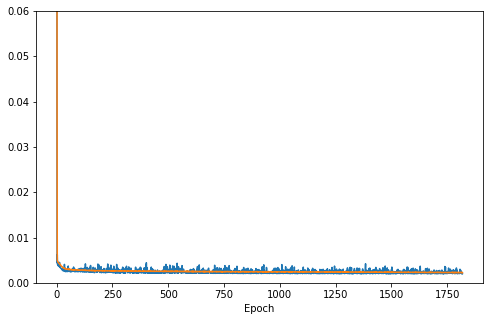

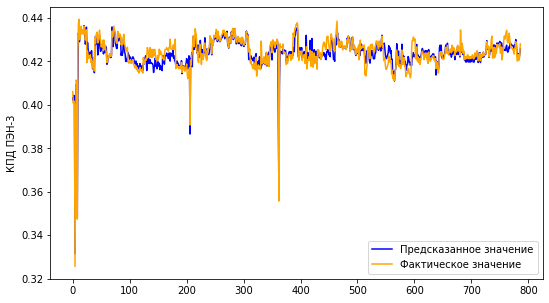

In [77]:
build_and_train(3) # обучение ПЭН-III

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 64)                448       
_________________________________________________________________
dense_173 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Progress: 1137/3500 {'loss': 9.460533874516841e-06, 'mae': 0.0023585124872624874, 'mse': 9.460533874516841e-06, 'val_loss': 2.5433966584387235e-05, 'val_mae': 0.002791027072817087, 'val_mse': 2.5433966584387235e-05}}}30/30 - 0s - loss: 1.6790e-05 - mae: 0.0028 - mse: 1.6790e-05
Testing set MAE: 0.00276, MSE: 0.00002


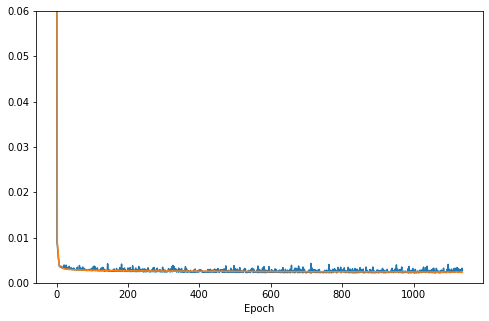

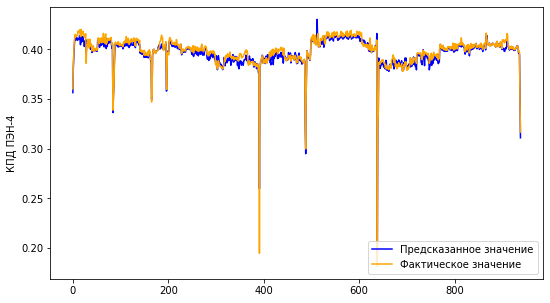

In [78]:
build_and_train(4) # обучение ПЭН-IV

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 64)                448       
_________________________________________________________________
dense_179 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Progress: 1457/3500 {'loss': 9.957134352589492e-06, 'mae': 0.0024581823963671923, 'mse': 9.957134352589492e-06, 'val_loss': 1.1296818229311612e-05, 'val_mae': 0.00250336155295372, 'val_mse': 1.1296818229311612e-05}05}}30/30 - 0s - loss: 1.2982e-05 - mae: 0.0026 - mse: 1.2982e-05
Testing set MAE: 0.00257, MSE: 0.00001


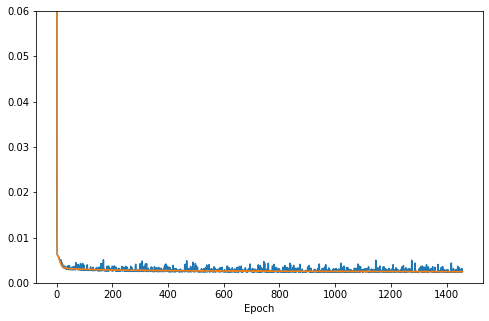

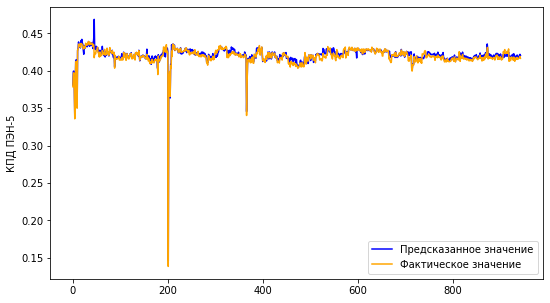

In [79]:
build_and_train(5) # обучение ПЭН-V

In [80]:
done_song = Audio('./success.wav', autoplay=True)
display(done_song)